In [1]:
# !mpirun -np 4 dask-mpi --scheduler-file ~/dask-scheduler.json

# client = Client(scheduler_file='~/dask-scheduler.json')

# import dask
# from dask.distributed import Client, LocalCluster
# cluster = LocalCluster()  # Launches a scheduler and workers locally
# client = Client(cluster)  # Connect to distributed cluster and override default
# # dask.config.set(scheduler='threads')

# client = Client(scheduler_file='~/dask-scheduler.json')



In [2]:
# import dask.array as ar

# x = ar.arange(100, chunks=10)

# x.sum().compute()

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

# import dask
# from dask.distributed import Client, LocalCluster
# cluster = LocalCluster()  # Launches a scheduler and workers locally
# client = Client(cluster)  # Connect to distributed cluster and override default
# dask.config.set(scheduler='threads')

from pyCascade import probePost, physics, utils
from matplotlib import pyplot as plt
import numpy as np
import os
from IPython.core.debugger import set_trace
import pandas as pd

category =  "config1"

############ Universal ################
scratch_home = os.getenv('SCRATCH') #need to set SCRATCH (even if there is no real SCRATCH) to the location where results are written
scratch_dir = f'{scratch_home}/Cascade/city_block_cfd'
home_dir = !pwd
home_dir = home_dir[0]

display(scratch_dir)
display(home_dir)

'/scratch/users/nbachand/Cascade/city_block_cfd'

'/home/users/nbachand/Cascade/city_block_cfd'

u_bulk is 5.686383242084054
domain height is 144.0
u_bulk is 5.6917076291193105
domain height is 144.0


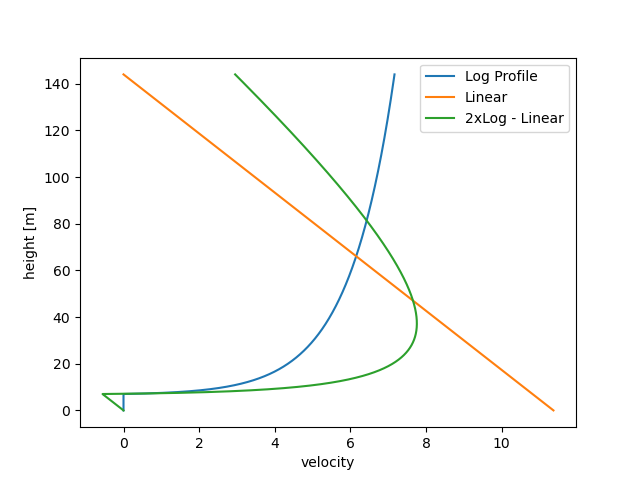

In [4]:
vK_const = .41
hm = 6
rho = 1.225
mu = 1.7894e-5
# Re_tau = 43300
Lz =  24*hm
z_ref = 10 # really y_refj
U_ref = 4

z_0 = 0.061*hm #used for convention, but really y_0
disp = 1.11*hm
shear_vel = vK_const*U_ref/np.log(z_ref/z_0)

plt.figure()
LES_params = {
    'uStar': shear_vel,
    'z0': z_0,
    'disp': disp,
    'Dt': .01,
    'z_values' : np.linspace(0,Lz,10000)
}
physics_setup = physics.LES_Physics(LES_params)
physics_setup.plot_log_wind()

physics_setup.plot_spinup_velocity()
physics_setup.plot_spinup_velocity2()

plt.legend()

plt.show()

In [5]:
display(
    physics_setup.LES_params['uStar'], 
    physics_setup.LES_params['z0'], 
    physics_setup.LES_params['disp'], 
    physics_setup.LES_params['u_bulk']
    )

0.4958117453795493

0.366

6.66

5.6917076291193105

In [6]:
physics_setup.calc_flatplate_quantities(
    rho = 1.224,
    mu = 1.7894e-5,
    yPlus = 500
    )

U infinity is 7.168206228236349 with L = 144.0
flat plate Reynolds number is 70606871.40740058
wall spacing is 0.03251964367353289 for y+ of 500


In [7]:
window_dim = hm/2/4

velocity_scaling = 1
ventilation_scaling = velocity_scaling/(window_dim**2)

norm_vel = probePost.quick_dict_apply(lambda data_df: data_df*velocity_scaling)
norm_vent = probePost.quick_dict_apply(lambda data_df: data_df*velocity_scaling)
abs_values = probePost.quick_dict_apply(lambda df: df.abs())
norm_data = lambda data_df : data_df*ventilation_scaling
flip_data = probePost.quick_dict_apply(lambda data_df: -data_df)


In [8]:
start = -25000#-250000
stop = -1000

# Run 2 - 0 deg wind

In [12]:
run = 2
qois = ['comp(u,0)']

probes_dir = f'{scratch_dir}/CHARLES/{category}/R{run}/probes/probesOut'

probes2 = probePost.Probes(probes_dir, file_type = "csv")
probes2.get_locations(probes_dir)

# plt.figure()
# plt.plot(probes2.probe_steps, probes2.probe_times)
# plt.show()

In [9]:
# probes2.to_parquet()

In [14]:
probes2 = probePost.Probes(probes_dir, file_type = "parquet")
probes2.get_locations(probes_dir)

In [12]:
# start = 534000 - probes2.probe_steps[-1]
# stop = -1000

# display(start)

In [ ]:
plot_params = {
    'plot_levels' : {
        # 'comp(u,0)' : np.linspace(0,.5,256),
        # 'comp(u,2)' : np.linspace(-1,1,256)
    },
    'horizontal spacing' : probes2.probe_times,
    'stack span' : 'y',
    'xlabel': 'time $[s]$',
    'ylabel' : r'height $[m]$',
    # 'ColorNorm': 'Centered',
    'veritcal scaling' : 1,
    'plot_every': 1000
}

# slice = probes.slice_into_df(slice_params)
(fig, ax) = probes2.contour_plots(
    names = [name for name in  probes2.probe_names if "col" in name], 
    steps = probes2.probe_steps[1000:-1000:],
    quants = ['comp(u,1)','comp(u,2)'],
    parrallel = True,
    plot_params = plot_params
#     processing = [norm_vel]
    )

plt.show()

In [19]:
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/velocity_history')

processing data took 29 seconds


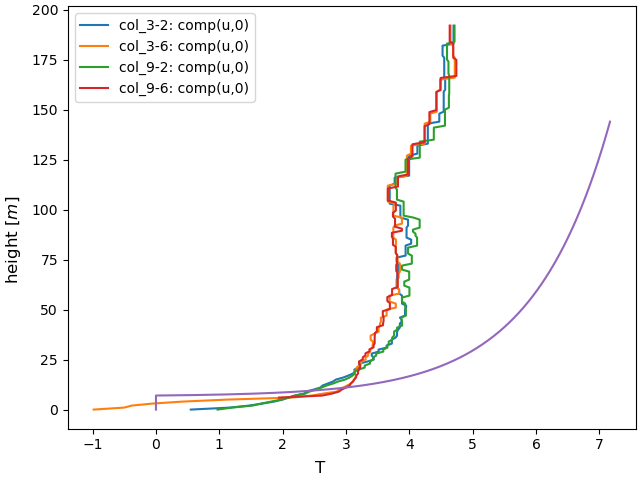

In [15]:
probes2.profile_plots(
    names = [name for name in  probes2.probe_names if "col" in name], 
    steps = probes2.probe_steps[start:stop],
    quants = qois,
    # stack = np.arange(0,300),
    plot_params = {
        'stack span' : 'y',
        'xlabel': 'T',
        'ylabel' : r'height $[m]$',
        'veritcal scaling' : 1
        },
    parrallel=True,
    processing = [probePost.time_average]
    )

plt.plot(physics_setup.LES_params['log_wind'], LES_params['z_values'])

In [12]:
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/velocity_profile')

processing data took 54 seconds


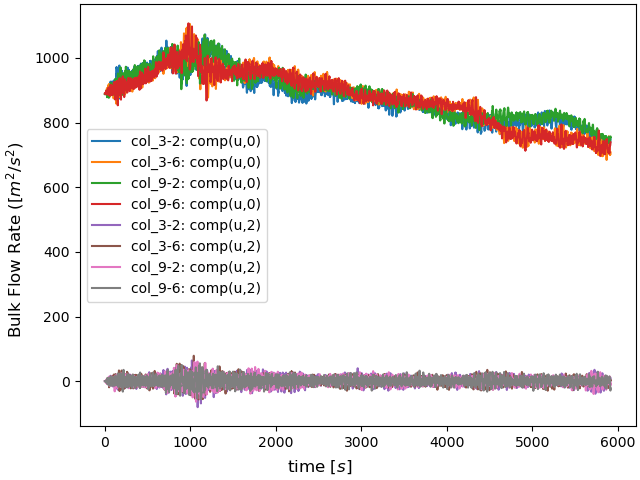

In [13]:
def bulk_flow(data_dict, tdata = None):
    for k, v in data_dict.items():
        name, _ = k
        y_loc = probes2.locations[name]['y']
        net_flow = np.trapz(v, y_loc, axis = 1)
        data_dict[k] = pd.DataFrame(net_flow, index = v.index)
    return data_dict

by = 1

(fig, ax) = probes2.time_plots(
    names = [name for name in  probes2.probe_names if "col" in name], 
    steps = probes2.probe_steps[0:stop:by],
    quants = qois,
    plot_params = {
        'stack span' : 'y',
        'ylabel': 'Bulk Flow Rate ($[m^2/s^2$)',
        'xlabel' : 'time $[s]$',
        'horizontal spacing' : probes2.probe_times,
        },
    processing = [bulk_flow],
    parrallel=True
    )



In [14]:
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/bulk_flow')

# Run 3 - 90 deg wind

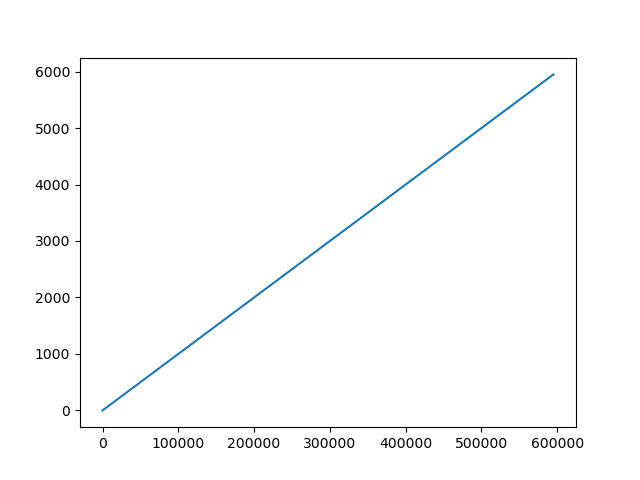

In [16]:
run = 3
qois = ['comp(u,2)']

probes_dir = f'{scratch_dir}/CHARLES/{category}/R{run}/probes/probesOut'

probes3 = probePost.Probes(probes_dir)
probes3.get_locations(probes_dir)

plt.figure()
plt.plot(probes3.probe_steps, probes3.probe_times)
plt.show()

In [17]:
probes3.to_parquet()

writing parquet for col_3-2 comp(u,2) took 12 seconds
writing parquet for col_3-2 p took 11 seconds
writing parquet for col_3-6 comp(u,0) took 12 seconds
writing parquet for col_3-6 comp(u,1) took 12 seconds
writing parquet for col_3-6 comp(u,2) took 13 seconds
writing parquet for col_3-6 p took 11 seconds
writing parquet for col_9-2 comp(u,0) took 12 seconds
writing parquet for col_9-2 comp(u,1) took 12 seconds
writing parquet for col_9-2 comp(u,2) took 12 seconds
writing parquet for col_9-2 p took 12 seconds
writing parquet for col_9-6 comp(u,0) took 11 seconds
writing parquet for col_9-6 comp(u,1) took 11 seconds
writing parquet for col_9-6 comp(u,2) took 12 seconds
writing parquet for col_9-6 p took 10 seconds
writing parquet for skylight_0-0_skylights comp(u,0) took 3 seconds
writing parquet for skylight_0-0_skylights comp(u,1) took 3 seconds
writing parquet for skylight_0-0_skylights comp(u,2) took 3 seconds
writing parquet for skylight_0-0_skylights p took 3 seconds
writing parq

In [16]:
 start = 345000 - probes3.probe_steps[-1]
# stop = -1000

# display(start)

processing data took 43 seconds
plotting took 15 seconds


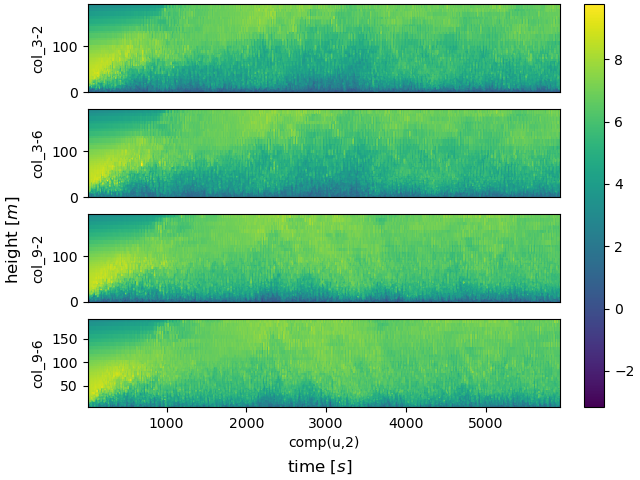

In [17]:
plot_params = {
    'plot_levels' : {
        # 'comp(u,0)' : np.linspace(0,.5,256),
        # 'comp(u,2)' : np.linspace(-1,1,256)
    },
    'horizontal spacing' : probes3.probe_times,
    'stack span' : 'y',
    'xlabel': 'time $[s]$',
    'ylabel' : r'height $[m]$',
    # 'ColorNorm': 'Centered',
    'veritcal scaling' : 1,
    'plot_every': 1000
}

# slice = probes.slice_into_df(slice_params)
(fig, ax) = probes3.contour_plots(
    names = [name for name in  probes3.probe_names if "col" in name], 
    steps = probes3.probe_steps[1000:-1000:],
    quants = qois,#,'comp(u,1)','comp(u,2)', 'p'],
    parrallel = True,
    plot_params = plot_params
#     processing = [norm_vel]
    )

plt.show()

In [18]:
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/velocity_history')

processing data took 42 seconds


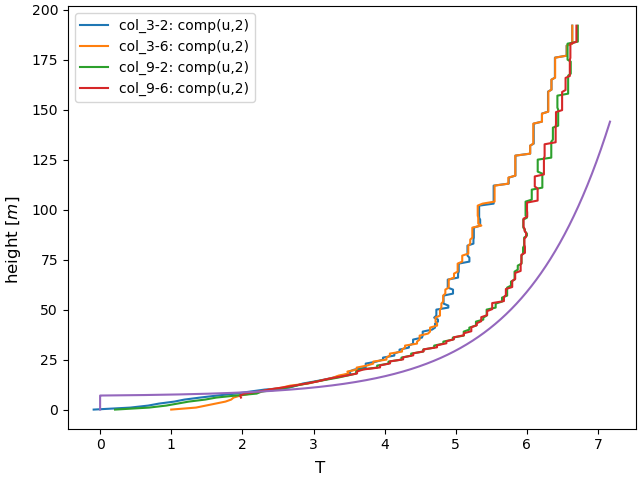

In [19]:
probes3.profile_plots(
    names = [name for name in  probes3.probe_names if "col" in name], 
    steps = probes3.probe_steps[start:stop],
    quants = qois,
    # stack = np.arange(0,300),
    plot_params = {
        'stack span' : 'y',
        'xlabel': 'T',
        'ylabel' : r'height $[m]$',
        'veritcal scaling' : 1
        },
    parrallel=True,
    processing = [probePost.time_average]
    )

plt.plot(physics_setup.LES_params['log_wind'], LES_params['z_values'])

In [20]:
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/velocity_profile')

processing data took 49 seconds


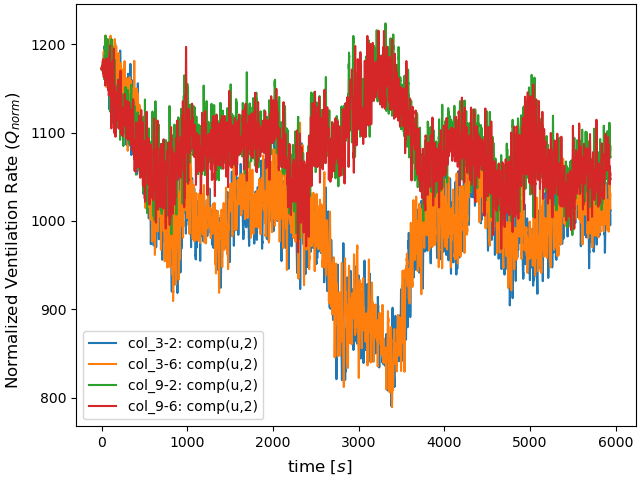

In [12]:
def bulk_flow(data_dict, tdata = None):
    for k, v in data_dict.items():
        name, _ = k
        y_loc = probes3.locations[name]['y']
        net_flow = np.trapz(v, y_loc, axis = 1)
        data_dict[k] = pd.DataFrame(net_flow, index = v.index)
    return data_dict

by = 1

(fig, ax) = probes3.time_plots(
    names = [name for name in  probes3.probe_names if "col" in name], 
    steps = probes3.probe_steps[0:stop:by],
    quants = qois,
    plot_params = {
        'stack span' : 'y',
        'ylabel': 'Normalized Ventilation Rate ($Q_{norm}$)',
        'xlabel' : 'time $[s]$',
        'horizontal spacing' : probes3.probe_times,
        },
    processing = [bulk_flow],
    parrallel=True
    )



In [13]:
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/bulk_flow')

# Run 4 - 180 deg wind

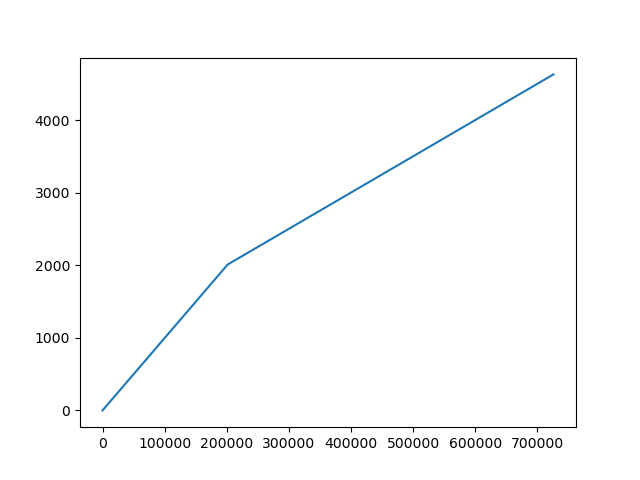

In [14]:
run = 4
qois = ['comp(u,0)']

probes_dir = f'{scratch_dir}/CHARLES/{category}/R{run}/probes/probesOut'

probes4 = probePost.Probes(probes_dir)
probes4.get_locations(probes_dir)

plt.figure()
plt.plot(probes4.probe_steps, probes4.probe_times)
plt.show()

In [24]:
# start = 446000 - probes4.probe_steps[-1]
# stop = -1000

# display(start)

processing data took 58 seconds
plotting took 18 seconds


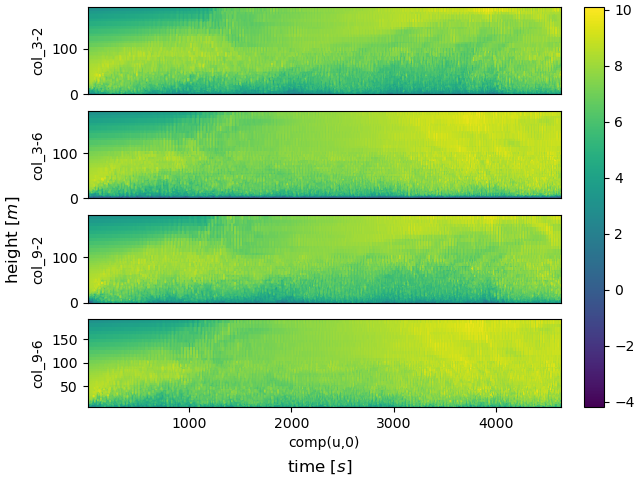

In [25]:
plot_params = {
    'plot_levels' : {
        # 'comp(u,0)' : np.linspace(0,.5,256),
        # 'comp(u,2)' : np.linspace(-1,1,256)
    },
    'horizontal spacing' : probes4.probe_times,
    'stack span' : 'y',
    'xlabel': 'time $[s]$',
    'ylabel' : r'height $[m]$',
    # 'ColorNorm': 'Centered',
    'veritcal scaling' : 1,
    'plot_every': 1000
}

# slice = probes.slice_into_df(slice_params)
(fig, ax) = probes4.contour_plots(
    names = [name for name in  probes4.probe_names if "col" in name], 
    steps = probes4.probe_steps[1000:-1000:],
    quants = qois,#,'comp(u,1)','comp(u,2)', 'p'],
    parrallel = True,
    plot_params = plot_params,
    processing = [flip_data]
    )

plt.show()

In [26]:
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/velocity_history')

processing data took 54 seconds


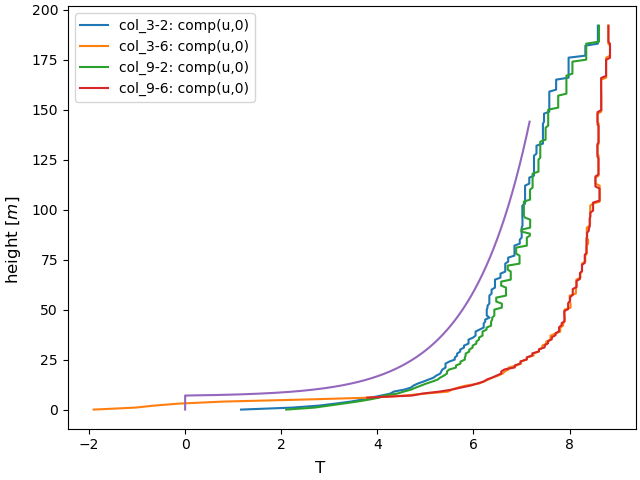

In [27]:
probes4.profile_plots(
    names = [name for name in  probes4.probe_names if "col" in name], 
    steps = probes4.probe_steps[start:stop],
    quants = qois,
    # stack = np.arange(0,300),
    plot_params = {
        'stack span' : 'y',
        'xlabel': 'T',
        'ylabel' : r'height $[m]$',
        'veritcal scaling' : 1
        },
    parrallel=True,
    processing = [flip_data, probePost.time_average]
    )

plt.plot(physics_setup.LES_params['log_wind'], LES_params['z_values'])

In [28]:
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/velocity_profile')

processing data took 68 seconds


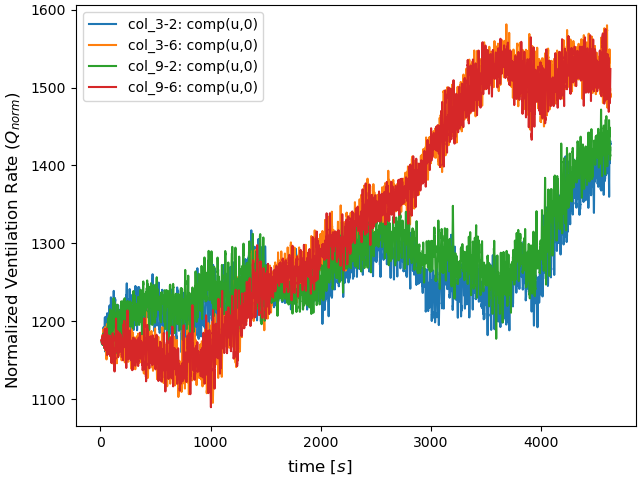

In [17]:
def bulk_flow(data_dict, tdata = None):
    for k, v in data_dict.items():
        name, _ = k
        y_loc = probes4.locations[name]['y']
        net_flow = np.trapz(v, y_loc, axis = 1)
        data_dict[k] = pd.DataFrame(net_flow, index = v.index)
    return data_dict

by = 1

(fig, ax) = probes4.time_plots(
    names = [name for name in  probes4.probe_names if "col" in name], 
    steps = probes4.probe_steps[1000:stop:by],
    quants = qois,
    plot_params = {
        'stack span' : 'y',
        'ylabel': 'Normalized Ventilation Rate ($Q_{norm}$)',
        'xlabel' : 'time $[s]$',
        'horizontal spacing' : probes4.probe_times,
        },
    processing = [flip_data, bulk_flow],
    parrallel=True
    )



In [19]:
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/bulk_flow')

# Run 5 - 270 deg wind

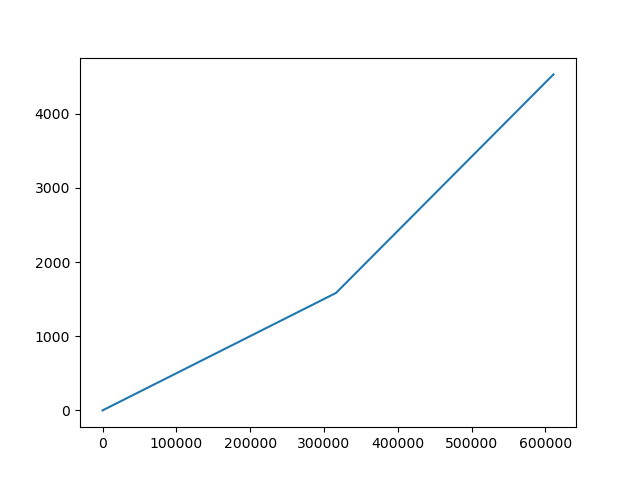

In [20]:
run = 5
qois = ['comp(u,2)']

probes_dir = f'{scratch_dir}/CHARLES/{category}/R{run}/probes/probesOut'

probes5 = probePost.Probes(probes_dir)
probes5.get_locations(probes_dir)

plt.figure()
plt.plot(probes5.probe_steps, probes5.probe_times)
plt.show()

In [32]:
# start = 316000 - probes5.probe_steps[-1]
# stop = -1000

# display(start)

processing data took 61 seconds
plotting took 14 seconds


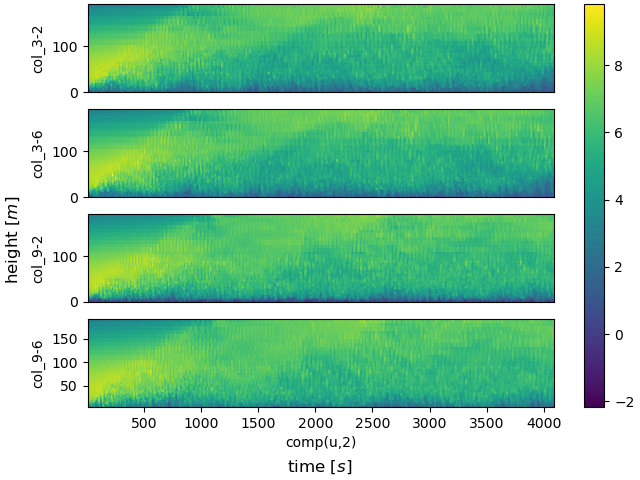

In [33]:
plot_params = {
    'plot_levels' : {
        # 'comp(u,0)' : np.linspace(0,.5,256),
        # 'comp(u,2)' : np.linspace(-1,1,256)
    },
    'horizontal spacing' : probes5.probe_times,
    'stack span' : 'y',
    'xlabel': 'time $[s]$',
    'ylabel' : r'height $[m]$',
    # 'ColorNorm': 'Centered',
    'veritcal scaling' : 1,
    'plot_every': 1000
}

# slice = probes.slice_into_df(slice_params)
(fig, ax) = probes5.contour_plots(
    names = [name for name in  probes5.probe_names if "col" in name], 
    steps = probes5.probe_steps[1000:-1000:],
    quants = qois,#,'comp(u,1)','comp(u,2)', 'p'],
    parrallel = True,
    plot_params = plot_params,
    processing = [flip_data]
    )

plt.show()

In [34]:
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/velocity_history')

processing data took 45 seconds


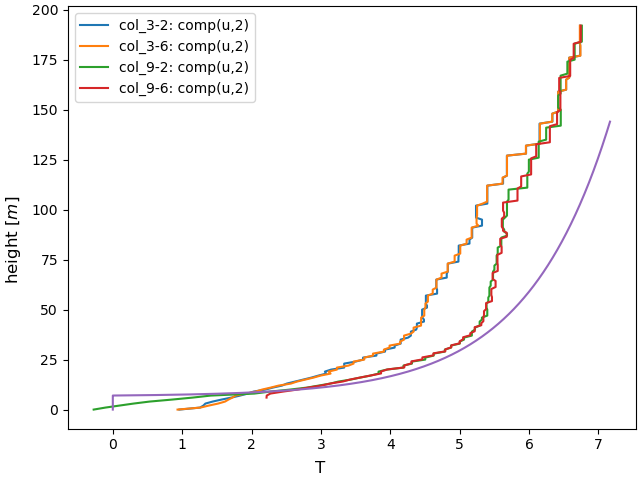

In [24]:
probes5.profile_plots(
    names = [name for name in  probes5.probe_names if "col" in name], 
    steps = probes5.probe_steps[start:stop],
    quants = qois,
    # stack = np.arange(0,300),
    plot_params = {
        'stack span' : 'y',
        'xlabel': 'T',
        'ylabel' : r'height $[m]$',
        'veritcal scaling' : 1
        },
    parrallel=True,
    processing = [flip_data, probePost.time_average]
    )

plt.plot(physics_setup.LES_params['log_wind'], LES_params['z_values'])

In [36]:
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/velocity_profile')

processing data took 76 seconds


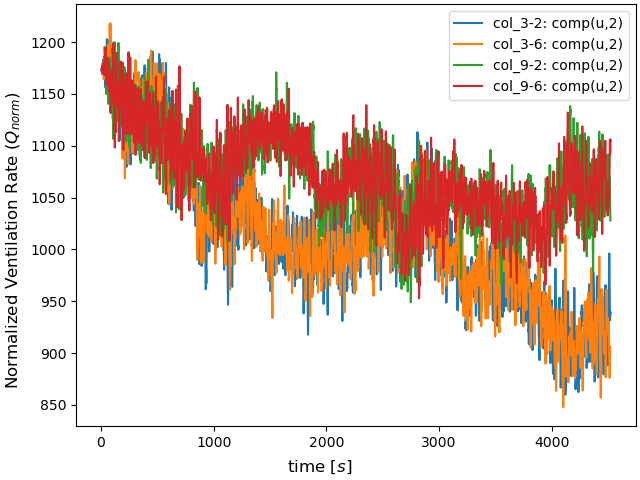

In [21]:
def bulk_flow(data_dict, tdata = None):
    for k, v in data_dict.items():
        name, _ = k
        y_loc = probes5.locations[name]['y']
        net_flow = np.trapz(v, y_loc, axis = 1)
        data_dict[k] = pd.DataFrame(net_flow, index = v.index)
    return data_dict

by = 1

(fig, ax) = probes5.time_plots(
    names = [name for name in  probes5.probe_names if "col" in name], 
    steps = probes5.probe_steps[1000:stop:by],
    quants = qois,
    plot_params = {
        'stack span' : 'y',
        'ylabel': 'Normalized Ventilation Rate ($Q_{norm}$)',
        'xlabel' : 'time $[s]$',
        'horizontal spacing' : probes5.probe_times,
        },
    processing = [flip_data, bulk_flow],
    parrallel=True
    )



In [22]:
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/bulk_flow')